In [26]:
import numpy as np
import pandas as pd

from etl import *

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import PolynomialFeatures

from sklearn.model_selection import train_test_split

import lightgbm as lgb
from sklearn.metrics import root_mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV

In [3]:
DATA_DIR = './Data/'
DATA_FILE = 'spotify_tracks_kaggle_weekly.csv'
ARTIST_FILE = 'spotify_tracks_artist_details.csv'

In [4]:
data_tracks = pd.read_csv(DATA_DIR + DATA_FILE)
data_artist = pd.read_csv(DATA_DIR + ARTIST_FILE)
data = pd.merge(data_tracks, data_artist, on='track_id', how='left')

In [5]:
RANDOM_STATE = 21
TEST_SIZE = 0.1

In [6]:
X = data.drop('popularity', axis=1)
y = data['popularity']

In [7]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE
)

In [8]:
drop_columns = ['track_id', 'artwork_url', 'track_url', 'track_name']

In [9]:
X_train = X_train.drop(drop_columns, axis=1, errors='ignore')
X_test = X_test.drop(drop_columns, axis=1, errors='ignore')

In [10]:
target = 'popularity'

onehot_col = ['language']
circle_of_fifths_col = ['key']
artist_name_col = ['artist_name']
album_name_col = ['album_name']

numeric_columns = list(X_train.columns[X_train.dtypes != object].difference(['key', 'mode']))

nan_columns = ['acousticness', 'danceability', 'energy', 'liveness', 'speechiness', 'tempo', 'valence']

In [11]:
numeric_pipeline = Pipeline(steps=[
    ('imputation', SimpleImputer()),
    ('polynomials', PolynomialFeatures()),
    ('scaling', StandardScaler())
])

artist_name_pipeline = Pipeline(steps=[
    ('encoding', FrequencyEncoder()),
    ('imputation', SimpleImputer()),
    ('scaling', StandardScaler())
])

album_name_pipeline = Pipeline(steps=[
    ('encoding', AlbumNameEncoder()),
    ('imputation', SimpleImputer())
])

circle_of_fifths_pipeline = Pipeline(steps=[
    ('encoding', CircleOfFifthsEncoding()),
    ('imputation', SimpleImputer())
])


transformations = ColumnTransformer(transformers=[
    
    ('onehot_encoding', OneHotEncoder(sparse_output=False), onehot_col),
    ('trigonometric_encoding', circle_of_fifths_pipeline, circle_of_fifths_col),
    ('artist_encoding', artist_name_pipeline, artist_name_col),
    ('album_encoding', album_name_pipeline, album_name_col),
    ('nummeric_processing', numeric_pipeline, numeric_columns)

], remainder='drop').set_output(transform='pandas')


preprocessing = Pipeline(steps=[
    
    ('null_values', ConvertNull(columns=nan_columns)),
    ('transformation', transformations)

]).set_output(transform='pandas')

In [12]:
X_train_preprocessed = preprocessing.fit_transform(X_train)
X_test_preprocessed = preprocessing.fit_transform(X_test)

In [13]:
train_data = lgb.Dataset(X_train_preprocessed, label=y_train)
test_data = lgb.Dataset(X_test_preprocessed, label=y_test, reference=train_data)

In [14]:
params = {
    'objective': 'regression',
    'metric': 'rmse',
    'boosting_type': 'gbdt',
    'learning_rate': 0.1,
    'num_leaves': 31,
    'max_depth': -1,
    'verbosity': -1,
}

In [20]:
param_grid = {
    'num_leaves': [31, 63, 127, 255],
    'learning_rate': [0.01, 0.03, 0.05, 0.07, 0.1, 0.15, 0.2, 0.5],
    'max_depth': [-1, 3, 5, 7, 9, 11],
    "subsample": [0.8, 1.0],
    "colsample_bytree": [0.8, 1.0]
}

grid = GridSearchCV(
    estimator=lgb.LGBMRegressor(objective='regression', random_state=RANDOM_STATE),
    param_grid=param_grid,
    scoring='neg_mean_squared_error',
    cv=5,
    verbose=0
)

grid.fit(X_train_preprocessed, y_train)
print(f"Best parameters: {grid.best_params_}")
print("Best RMSE:", np.sqrt(-grid.best_score_))

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016323 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 28793
[LightGBM] [Info] Number of data points in the train set: 44868, number of used features: 130
[LightGBM] [Info] Start training from score 15.345302
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020074 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 28789
[LightGBM] [Info] Number of data points in the train set: 44868, number of used features: 130
[LightGBM] [Info] Start training from score 15.307569
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead

KeyboardInterrupt: 

In [21]:
params = {
    'objective': 'regression',
    'metric': 'rmse',
    'boosting_type': 'gbdt',
    'learning_rate': 0.07,
    'num_leaves': 255,
    'max_depth': -1,
    'colsample_bytree': 0.8,
    'subsample': 0.8,
    'verbosity': -1,
}

In [22]:
model = lgb.train(
    params,
    train_data,
)

In [27]:
y_pred = model.predict(X_test_preprocessed, num_iteration=model.best_iteration)
rmse = root_mean_squared_error(y_test, y_pred)
rmse

r2_score(y_test, y_pred)

0.3694953043782303

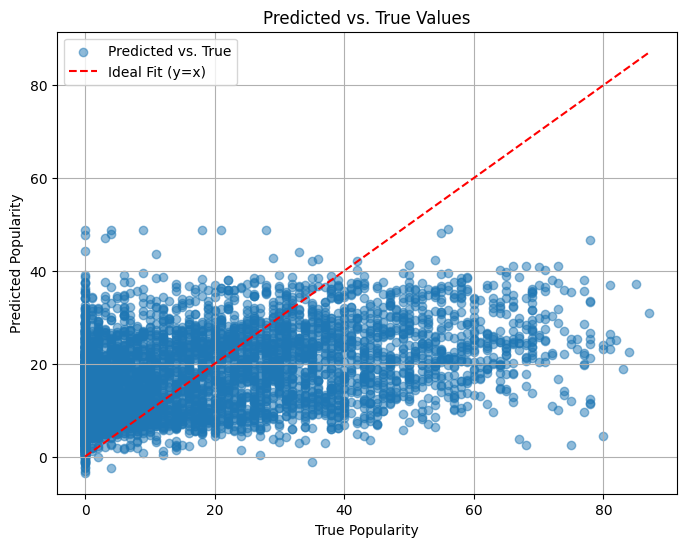

In [65]:
from matplotlib import pyplot as plt

plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.5, label='Predicted vs. True')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--', label='Ideal Fit (y=x)')
plt.xlabel('True Popularity')
plt.ylabel('Predicted Popularity')
plt.title('Predicted vs. True Values')
plt.legend()
plt.grid()
plt.show()

<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

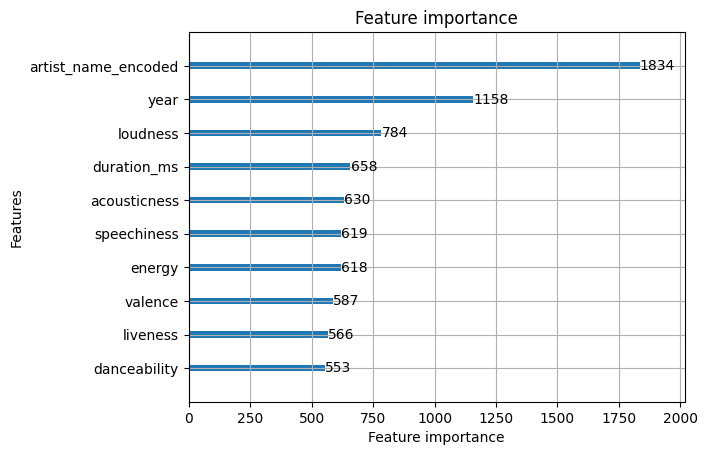

In [70]:
lgb.plot_importance(model, max_num_features=10)

In [ ]:
from hyperopt import hp, fmin, tpe, Trials, STATUS_OK
lgb_reg_params = {
    'learning_rate':    hp.uniform('learning_rate',0.1,1),
    'max_depth':        hp.choice('max_depth',        np.arange(2, 100, 1, dtype=int)),
    'min_child_weight': hp.choice('min_child_weight', np.arange(1, 50, 1, dtype=int)),
    'colsample_bytree': hp.uniform('colsample_bytree',0.4,1),
    'subsample':        hp.uniform('subsample', 0.6, 1),
    'num_leaves':       hp.choice('num_leaves',       np.arange(1, 200, 1, dtype=int)),
    'min_split_gain':   hp.uniform('min_split_gain', 0, 1),
    'reg_alpha':        hp.uniform('reg_alpha',0,1),
    'reg_lambda':       hp.uniform('reg_lambda',0,1),
    'n_estimators':     5
}
def f(params):
    lgbm = lgb.LGBMRegressor(n_jobs=-1,early_stopping_rounds=None,random_state=RANDOM_STATE,**params)
    score = cross_val_score(lgbm, X_train, y_train, cv=2,scoring=rmsle,n_jobs=-1).mean()
    return score

trials = Trials()
result = fmin(
    fn=f,                           # objective function
    space=lgb_reg_params,   # parameter space
    algo=tpe.suggest,               # surrogate algorithm
    max_evals=50,                  # no. of evaluations
    trials=trials                   # trials object that keeps track of the sample results (optional)
)
print(result)